In [75]:
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd


import parselmouth
from parselmouth.praat import call



from tqdm import tqdm

# Load paths

In [76]:
train_df = pd.read_csv("data/path/train.csv")
test_df = pd.read_csv("data/path/test.csv")
val_df = pd.read_csv("data/path/val.csv")

print("Train: ", train_df.shape)
print("Test: ", test_df.shape)
print("Val: ", val_df.shape)


Train:  (3073, 2)
Test:  (391, 2)
Val:  (440, 2)


# Extract features

In [77]:
def create_dataset(df, sr=22050, augment_data=False):
    """
    Extract feature 
    
    Args:
        df: dataframe with path of file and associated emotion
        sr: sampling rate
     
        
    Returns:
        (X, :Extracted feature df
        y   :Associated label array
        )
    """


    y = []  # Labels (emotions)
    features = {
            'pitch_median': [],
            'pitch_mean': [],
            'pitch_std': [],
            'local_jitter': [],
            'local_shimmer': [],
            'hnr': [],
            'energy_mean': [],
            'energy_std': [],
            'zcr_mean': [],
            'zcr_std': [],
            'mfcc_mean_0': [],
            'mfcc_mean_1': [],
            'mfcc_mean_2': [],
            'mfcc_mean_3': [],
            'mfcc_mean_4': [],
            'mfcc_mean_5': [],
            'mfcc_mean_6': [],
            'mfcc_mean_7': [],
            'mfcc_mean_8': [],
            'mfcc_mean_9': [],
            'mfcc_mean_10': [],
            'mfcc_mean_11': [],
            'mfcc_mean_12': [],
            'mfcc_std_0': [],
            'mfcc_std_1': [],
            'mfcc_std_2': [],
            'mfcc_std_3': [],
            'mfcc_std_4': [],
            'mfcc_std_5': [],
            'mfcc_std_6': [],
            'mfcc_std_7': [],
            'mfcc_std_8': [],
            'mfcc_std_9': [],
            'mfcc_std_10': [],
            'mfcc_std_11': [],
            'mfcc_std_12': []
        }


    for row in tqdm(df.itertuples(index=False), total=len(df)):

        path = row.path
        emotion = row.emotion
        audio, sr = librosa.load(path, sr=None)  # Usa sr=None per mantenere la frequenza originale
        
        audio_array = [] #Store orignal audio, and augmented audios
        audio_array.append(audio)

        
        if augment_data:
            if emotion == 6:

                #DATA AUGMENTATION
                #speed up
                audio_stretched = librosa.effects.time_stretch(y=audio, rate=1.1)  # speend up by 10%
                #pitch up
                audio_pitched = librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=2)  
                # 0.5 time shift
                shift = int(0.5 * sr) 
                audio_shifted = np.roll(audio, shift)
                # noise injection
                noise = np.random.normal(0, 0.05, len(audio))
                audio_noisy = audio + noise 

                #audio_array.append(audio_stretched)
                audio_array.append(audio_pitched)
                #audio_array.append(audio_shifted)
                audio_array.append(audio_noisy)
        
        # Extract features
        for audio in audio_array:
            y.append(emotion)
            sound = parselmouth.Sound(values=audio, sampling_frequency=sr)

            # PITCH
            f0, voiced_flag, voiced_prob = librosa.pyin(audio, fmin=50, fmax=500)
            if np.any(voiced_flag):
                features['pitch_median'].append(np.median(f0[voiced_flag]))
                features['pitch_mean'].append(np.mean(f0[voiced_flag]))
                features['pitch_std'].append(np.std(f0[voiced_flag]))
            else:
                features['pitch_median'].append(0)
                features['pitch_mean'].append(0)
                features['pitch_std'].append(0)

            # JITTER
            pointProcess = call(sound, "To PointProcess (periodic, cc)", 50, 500)
            features['local_jitter'].append(call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3))

            # SHIMMER
            features['local_shimmer'].append(call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6))

            # HNR 
            harmonicity = call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
            features['hnr'].append(call(harmonicity, "Get mean", 0, 0))

            # ENERGY
            rms = librosa.feature.rms(y=audio)[0]
            features['energy_mean'].append(np.mean(rms))
            features['energy_std'].append(np.std(rms))

            # ZCR
            zcr = librosa.feature.zero_crossing_rate(y=audio)[0]
            features['zcr_mean'].append(np.mean(zcr))
            features['zcr_std'].append(np.std(zcr))

            # MFCC
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
            for i in range(13):
                features[f'mfcc_mean_{i}'].append(np.mean(mfccs[i, :]))
                features[f'mfcc_std_{i}'].append(np.std(mfccs[i, :]))
         

    X = pd.DataFrame(features)  
    y = np.array(y) 
    return X, y
  

In [78]:
X_train, y_train = create_dataset(train_df, augment_data=False)
X_val, y_val = create_dataset(val_df, augment_data=False)
X_test, y_test = create_dataset(test_df, augment_data=False)

print("Train: ", X_train.shape)
print("Val: ", X_val.shape)
print("Test: ", X_test.shape)

100%|██████████| 391/391 [02:22<00:00,  2.75it/s]

Train:  (3073, 36)
Val:  (440, 36)
Test:  (391, 36)


# Plot

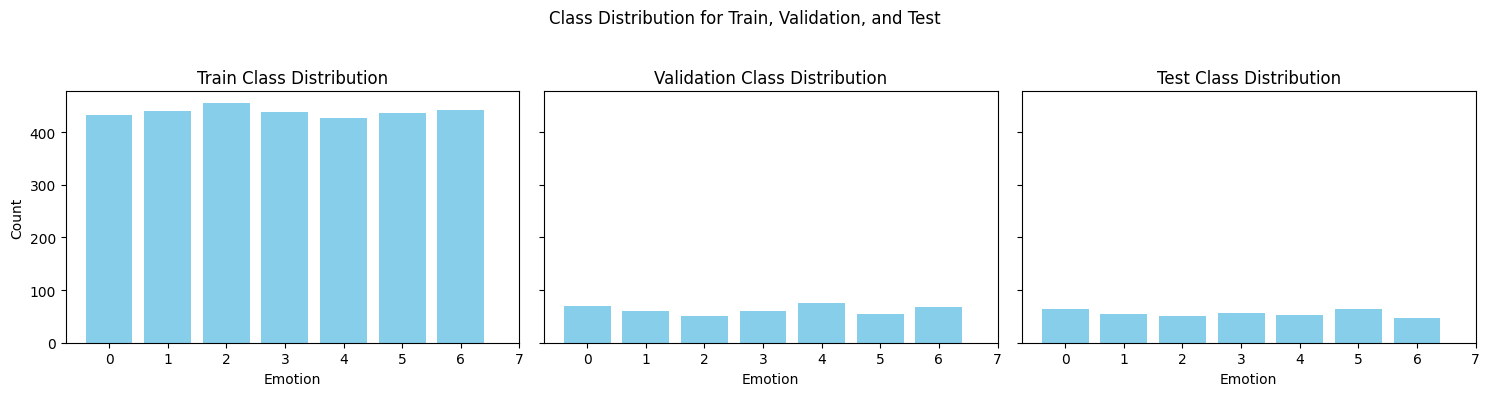

In [79]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

axs[0].hist(y_train, bins=range(8), rwidth=0.8, align='left', color='skyblue')
axs[0].set_title('Train Class Distribution')
axs[0].set_xlabel('Emotion')
axs[0].set_ylabel('Count')
axs[0].set_xticks(range(8))

axs[1].hist(y_val, bins=range(8), rwidth=0.8, align='left', color='skyblue')
axs[1].set_title('Validation Class Distribution')
axs[1].set_xlabel('Emotion')
axs[1].set_xticks(range(8))

axs[2].hist(y_test, bins=range(8), rwidth=0.8, align='left', color='skyblue')
axs[2].set_title('Test Class Distribution')
axs[2].set_xlabel('Emotion')
axs[2].set_xticks(range(8))

plt.suptitle('Class Distribution for Train, Validation, and Test')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Save dataset

In [80]:
def save_dataset(X_train, X_val, X_test, y_train, y_val, y_test, output_dir="data/processed_data_features"):
    os.makedirs(output_dir, exist_ok=True)
    np.save(os.path.join(output_dir, "X_train.npy"), X_train)
    np.save(os.path.join(output_dir, "X_val.npy"), X_val)
    np.save(os.path.join(output_dir, "X_test.npy"), X_test)
    np.save(os.path.join(output_dir, "y_train.npy"), y_train)
    np.save(os.path.join(output_dir, "y_val.npy"), y_val)
    np.save(os.path.join(output_dir, "y_test.npy"), y_test)

save_dataset(X_train, X_val, X_test, y_train, y_val, y_test)